In [1]:
!pip install tf-nightly-2.0-preview

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-dev20191002


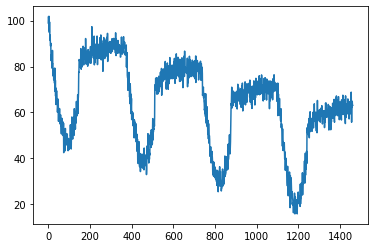

In [70]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.sin(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 100
series = trend(time, 0.1)  
baseline = 100
amplitude = -50
slope = -0.025
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plt.plot(series)

In [71]:
# def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
#   series = tf.expand_dims(series, axis=-1)
#   dataset = tf.data.Dataset.from_tensor_slices(series)
#   dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
#   dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
#   dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
#   dataset = dataset.batch(batch_size).prefetch(1)
#   return dataset

def windowed_dataset(series1, window_size, batch_size, shuffle_buffer):
    series1 = tf.expand_dims(series1, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series1)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


In [73]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])


lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 6s 697ms/step - loss: 105.7272 - mae: 106.2506
Epoch 2/100
8/8 [==============================] - 1s 138ms/step - loss: 104.8997 - mae: 105.4440
Epoch 3/100
8/8 [==============================] - 1s 122ms/step - loss: 103.6936 - mae: 104.1494
Epoch 4/100
8/8 [==============================] - 1s 136ms/step - loss: 102.0971 - mae: 102.5261
Epoch 5/100
8/8 [==============================] - 1s 122ms/step - loss: 99.9162 - mae: 100.6248
Epoch 6/100
8/8 [==============================] - 1s 110ms/step - loss: 97.8263 - mae: 98.4356
Epoch 7/100
8/8 [==============================] - 1s 136ms/step - loss: 95.4362 - mae: 95.9278
Epoch 8/100
8/8 [==============================] - 1s 171ms/step - loss: 92.5662 - mae: 93.0193
Epoch 9/100
8/8 [==============================] - 1s 110ms/step - loss: 88.9865 - mae: 89.6017
Epoch 10/100
8/8 [==============================] - 1s 109ms/step - loss: 85.0770 - mae: 85.5780
Epoch 11/100
8/8 [============

8/8 [==============================] - 1s 105ms/step - loss: 28.4060 - mae: 29.1656
Epoch 87/100
8/8 [==============================] - 1s 117ms/step - loss: 15.0616 - mae: 15.6698
Epoch 88/100
8/8 [==============================] - 1s 169ms/step - loss: 11.5375 - mae: 12.0615
Epoch 89/100
8/8 [==============================] - 1s 107ms/step - loss: 22.9059 - mae: 22.5548
Epoch 90/100
8/8 [==============================] - 1s 133ms/step - loss: 23.0216 - mae: 23.8463
Epoch 91/100
8/8 [==============================] - 1s 140ms/step - loss: 16.3109 - mae: 16.8920
Epoch 92/100
8/8 [==============================] - 1s 140ms/step - loss: 24.5424 - mae: 24.4551
Epoch 93/100
8/8 [==============================] - 1s 147ms/step - loss: 23.3204 - mae: 24.1788
Epoch 94/100
8/8 [==============================] - 1s 120ms/step - loss: 22.3857 - mae: 23.0794
Epoch 95/100
8/8 [==============================] - 1s 110ms/step - loss: 16.5117 - mae: 17.0066
Epoch 96/100
8/8 [=========================

[1e-08, 0.0001, 0, 30]

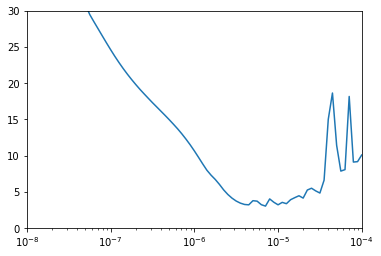

In [74]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [75]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
31/31 [==============================] - 4s 126ms/step - loss: 31.2083 - mae: 32.0711
Epoch 2/500
31/31 [==============================] - 1s 47ms/step - loss: 13.3612 - mae: 13.9023
Epoch 3/500
31/31 [==============================] - 1s 45ms/step - loss: 9.7821 - mae: 10.3113
Epoch 4/500
31/31 [==============================] - 1s 46ms/step - loss: 7.8176 - mae: 8.3124
Epoch 5/500
31/31 [==============================] - 1s 46ms/step - loss: 6.9341 - mae: 7.4325
Epoch 6/500
31/31 [==============================] - 2s 51ms/step - loss: 6.4862 - mae: 6.9766
Epoch 7/500
31/31 [==============================] - 1s 46ms/step - loss: 6.1013 - mae: 6.5841
Epoch 8/500
31/31 [==============================] - 2s 48ms/step - loss: 5.6581 - mae: 6.1436
Epoch 9/500
31/31 [==============================] - 1s 46ms/step - loss: 5.3750 - mae: 5.8579
Epoch 10/500
31/31 [==============================] - 2s 53ms/step - loss: 5.0204 - mae: 5.4998
Epoch 11/500
31/31 [=======================

31/31 [==============================] - 1s 47ms/step - loss: 2.7191 - mae: 3.1827
Epoch 87/500
31/31 [==============================] - 1s 46ms/step - loss: 2.6980 - mae: 3.1637
Epoch 88/500
31/31 [==============================] - 1s 48ms/step - loss: 2.6707 - mae: 3.1316
Epoch 89/500
31/31 [==============================] - 1s 44ms/step - loss: 2.7005 - mae: 3.1730
Epoch 90/500
31/31 [==============================] - 1s 47ms/step - loss: 2.6956 - mae: 3.1605
Epoch 91/500
31/31 [==============================] - 1s 46ms/step - loss: 2.6663 - mae: 3.1332
Epoch 92/500
31/31 [==============================] - 2s 51ms/step - loss: 2.6180 - mae: 3.0873
Epoch 93/500
31/31 [==============================] - 1s 44ms/step - loss: 2.7240 - mae: 3.1893
Epoch 94/500
31/31 [==============================] - 2s 51ms/step - loss: 2.6654 - mae: 3.1229
Epoch 95/500
31/31 [==============================] - 1s 45ms/step - loss: 2.6961 - mae: 3.1620
Epoch 96/500
31/31 [==============================] -

31/31 [==============================] - 1s 47ms/step - loss: 2.5068 - mae: 2.9691
Epoch 171/500
31/31 [==============================] - 1s 47ms/step - loss: 2.4438 - mae: 2.9067
Epoch 172/500
31/31 [==============================] - 1s 46ms/step - loss: 2.4080 - mae: 2.8731
Epoch 173/500
31/31 [==============================] - 1s 48ms/step - loss: 2.4838 - mae: 2.9509
Epoch 174/500
31/31 [==============================] - 2s 48ms/step - loss: 2.4344 - mae: 2.8953
Epoch 175/500
31/31 [==============================] - 2s 50ms/step - loss: 2.4319 - mae: 2.8939
Epoch 176/500
31/31 [==============================] - 1s 46ms/step - loss: 2.4293 - mae: 2.8849
Epoch 177/500
31/31 [==============================] - 1s 46ms/step - loss: 2.4502 - mae: 2.9036
Epoch 178/500
31/31 [==============================] - 2s 49ms/step - loss: 2.4561 - mae: 2.9128
Epoch 179/500
31/31 [==============================] - 1s 45ms/step - loss: 2.4643 - mae: 2.9247
Epoch 180/500
31/31 [=======================

31/31 [==============================] - 1s 45ms/step - loss: 2.4653 - mae: 2.9329
Epoch 255/500
31/31 [==============================] - 1s 45ms/step - loss: 2.4241 - mae: 2.8894
Epoch 256/500
31/31 [==============================] - 1s 47ms/step - loss: 2.3791 - mae: 2.8413
Epoch 257/500
31/31 [==============================] - 1s 45ms/step - loss: 2.3671 - mae: 2.8311
Epoch 258/500
31/31 [==============================] - 1s 46ms/step - loss: 2.3736 - mae: 2.8404
Epoch 259/500
31/31 [==============================] - 1s 46ms/step - loss: 2.3681 - mae: 2.8264
Epoch 260/500
31/31 [==============================] - 1s 48ms/step - loss: 2.3988 - mae: 2.8605
Epoch 261/500
31/31 [==============================] - 1s 46ms/step - loss: 2.3924 - mae: 2.8450
Epoch 262/500
31/31 [==============================] - 1s 46ms/step - loss: 2.4026 - mae: 2.8659
Epoch 263/500
31/31 [==============================] - 1s 46ms/step - loss: 2.4208 - mae: 2.8823
Epoch 264/500
31/31 [=======================

31/31 [==============================] - 1s 46ms/step - loss: 2.3425 - mae: 2.7997
Epoch 339/500
31/31 [==============================] - 1s 46ms/step - loss: 2.3307 - mae: 2.7956
Epoch 340/500
31/31 [==============================] - 1s 45ms/step - loss: 2.3421 - mae: 2.8079
Epoch 341/500
31/31 [==============================] - 1s 45ms/step - loss: 2.3555 - mae: 2.8139
Epoch 342/500
31/31 [==============================] - 2s 49ms/step - loss: 2.3317 - mae: 2.7987
Epoch 343/500
31/31 [==============================] - 1s 46ms/step - loss: 2.3333 - mae: 2.7891
Epoch 344/500
31/31 [==============================] - 2s 49ms/step - loss: 2.3542 - mae: 2.8157
Epoch 345/500
31/31 [==============================] - 1s 48ms/step - loss: 2.3501 - mae: 2.8111
Epoch 346/500
31/31 [==============================] - 2s 49ms/step - loss: 2.3423 - mae: 2.8049
Epoch 347/500
31/31 [==============================] - 1s 44ms/step - loss: 2.3294 - mae: 2.7901
Epoch 348/500
31/31 [=======================

31/31 [==============================] - 1s 46ms/step - loss: 2.3537 - mae: 2.8162
Epoch 423/500
31/31 [==============================] - 1s 47ms/step - loss: 2.3382 - mae: 2.7985
Epoch 424/500
31/31 [==============================] - 1s 46ms/step - loss: 2.3387 - mae: 2.7986
Epoch 425/500
31/31 [==============================] - 1s 47ms/step - loss: 2.4210 - mae: 2.8827
Epoch 426/500
31/31 [==============================] - 1s 47ms/step - loss: 2.3327 - mae: 2.7910
Epoch 427/500
31/31 [==============================] - 1s 48ms/step - loss: 2.3428 - mae: 2.8017
Epoch 428/500
31/31 [==============================] - 1s 46ms/step - loss: 2.4160 - mae: 2.8818
Epoch 429/500
31/31 [==============================] - 2s 51ms/step - loss: 2.5314 - mae: 3.0011
Epoch 430/500
31/31 [==============================] - 2s 49ms/step - loss: 2.3704 - mae: 2.8339
Epoch 431/500
31/31 [==============================] - 1s 48ms/step - loss: 2.3540 - mae: 2.8132
Epoch 432/500
31/31 [=======================

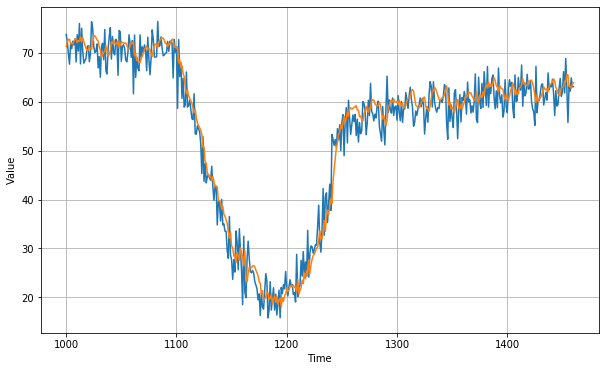

In [76]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)


In [77]:
time_valid

array([1000., 1001., 1002., 1003., 1004., 1005., 1006., 1007., 1008.,
       1009., 1010., 1011., 1012., 1013., 1014., 1015., 1016., 1017.,
       1018., 1019., 1020., 1021., 1022., 1023., 1024., 1025., 1026.,
       1027., 1028., 1029., 1030., 1031., 1032., 1033., 1034., 1035.,
       1036., 1037., 1038., 1039., 1040., 1041., 1042., 1043., 1044.,
       1045., 1046., 1047., 1048., 1049., 1050., 1051., 1052., 1053.,
       1054., 1055., 1056., 1057., 1058., 1059., 1060., 1061., 1062.,
       1063., 1064., 1065., 1066., 1067., 1068., 1069., 1070., 1071.,
       1072., 1073., 1074., 1075., 1076., 1077., 1078., 1079., 1080.,
       1081., 1082., 1083., 1084., 1085., 1086., 1087., 1088., 1089.,
       1090., 1091., 1092., 1093., 1094., 1095., 1096., 1097., 1098.,
       1099., 1100., 1101., 1102., 1103., 1104., 1105., 1106., 1107.,
       1108., 1109., 1110., 1111., 1112., 1113., 1114., 1115., 1116.,
       1117., 1118., 1119., 1120., 1121., 1122., 1123., 1124., 1125.,
       1126., 1127.,

In [78]:
rnn_forecast

array([71.26199 , 72.2584  , 72.751305, 72.77132 , 71.83647 , 71.93907 ,
       71.7475  , 72.40231 , 72.70654 , 72.878624, 72.0906  , 72.48468 ,
       72.3218  , 73.25827 , 72.20417 , 73.08507 , 72.30308 , 71.58578 ,
       70.9216  , 70.384125, 70.60025 , 71.35659 , 70.800835, 70.7378  ,
       72.11346 , 73.41262 , 73.49883 , 73.110985, 72.66618 , 72.415436,
       71.12011 , 70.58649 , 69.16584 , 69.51666 , 70.08527 , 70.287346,
       71.43235 , 70.464935, 69.32056 , 69.62292 , 70.379845, 72.21893 ,
       71.87537 , 72.67727 , 72.005554, 71.72627 , 72.11755 , 72.444214,
       71.07815 , 71.55739 , 72.30629 , 72.05555 , 72.07506 , 71.91496 ,
       72.022285, 71.57698 , 70.889435, 70.68325 , 71.42277 , 72.147606,
       71.85695 , 72.34264 , 69.38691 , 69.80494 , 68.44201 , 68.34714 ,
       68.18674 , 67.96004 , 69.07651 , 69.257484, 70.04613 , 70.67956 ,
       71.059654, 71.415405, 70.610275, 70.97036 , 70.56904 , 69.93313 ,
       69.25405 , 70.481476, 71.73426 , 71.76711 , 

In [79]:
model.save("x_train_tuning_Rishie_2.h5")
print("Saved model to disk")

Saved model to disk
